In [10]:
using DifferentialEquations, Flux, DiffEqFlux, Optim, DiffEqSensitivity, Plots, OrdinaryDiffEq, Zygote, StaticArrays, LinearAlgebra, BenchmarkTools, PaddedViews, LaTeXStrings, PGFPlotsX, PlotThemes, ApproxFun

In [2]:
pgfplotsx();
Plots.PGFPlotsXBackend();

In [3]:
const σ0 = Hermitian(Complex{Float64}[1 0; 0 1]);
const σx = Hermitian(Complex{Float64}[0 1; 1 0]);
const σy = Hermitian(Complex{Float64}[0 -im; im 0]);
const σz = Hermitian(Complex{Float64}[1 0; 0 -1]);

In [4]:
Ωp_nn = FastChain(FastDense(1,32), FastDense(32,32,tanh), FastDense(32,32,tanh), FastDense(32,2))
θ_nn = initial_params(Ωp_nn);

In [5]:
const β = 2π*0.2;

const tol = 1e-7;

const Hϵ = Hermitian(Complex{Float64}[1 0; 0 -1;]);


const T = 6.0;
tspan = (0.0, T);

const θ = π/2;
const Utarget = cos(θ/2)*σ0 + sin(θ/2)*im*σz;
    
const steepness = 20*T;
smooth_square_envelope(t) = coth(steepness/4)*( tanh(steepness*t/(4*T)) - tanh(steepness*(t-T)/(4*T)) ) - 1;

function schrodinger_nn(u, p, t)
    @views @inbounds U = u[1:2,1:2];
    @views @inbounds ℰ = u[3:4,1:2];
    envelope = smooth_square_envelope(t);
    nn_output = Ωp_nn([t/T],p)
    @inbounds Ω = envelope*( nn_output[1]*sin(nn_output[2]) )
    @inbounds H = Hermitian([β Ω; Ω -β]);
    local dℰ = Hermitian(U'*Hϵ*U);
    return [-im*H*U; dℰ; dℰ*ℰ - ℰ*dℰ]; # 1/2 of (dℰ*ℰ - ℰ*dℰ)/2 is in cost_adjoint_nn
end

const u0 = Complex{Float64}[1 0; 0 1; 0 0; 0 0; 0 0; 0 0];

ode_nn = ODEProblem(schrodinger_nn, u0, tspan, θ);

function callback(p, cost)
    return cost < 1e-7
end


function cost_adjoint_nn(p, w=1.0)
    ode_sol = solve(ode_nn, BS5(), p=Complex{Float64}.(p), abstol=tol, reltol=tol)
    usol = last(ode_sol)
    @views @inbounds Ugate = usol[1:2,1:2];
    @views @inbounds ℰ = usol[3:4, 1:2];
    @views @inbounds ℰ2 = usol[5:6, 1:2];

    loss = abs(1.0 - abs(tr(Ugate*Utarget')/2)^2) + w^2*(norm(ℰ)/2)^2 + 4*w^4*(norm(ℰ2)/4)^2

    return loss
end

cost_adjoint_nn (generic function with 2 methods)

In [6]:
optimized_sol_nn = DiffEqFlux.sciml_train(p -> cost_adjoint_nn(p, 0.08), θ_nn, RADAM(0.003), maxiters = 1000)

loss: 0.0868: 100%|█████████████████████████████████████| Time: 0:02:58


 * Status: success

 * Candidate solution
    Final objective value:     8.681951e-02

 * Found with
    Algorithm:     RADAM

 * Convergence measures
    |x - x'|               = NaN ≰ 0.0e+00
    |x - x'|/|x'|          = NaN ≰ 0.0e+00
    |f(x) - f(x')|         = NaN ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = NaN ≰ 0.0e+00
    |g(x)|                 = NaN ≰ 0.0e+00

 * Work counters
    Seconds run:   258  (vs limit Inf)
    Iterations:    1000
    f(x) calls:    1000
    ∇f(x) calls:   1000


In [11]:
optimized_sol_nn2 = DiffEqFlux.sciml_train(p -> cost_adjoint_nn(p, 0.08), optimized_sol_nn.minimizer, BFGS(initial_stepnorm=0.001), maxiters = 1000, allow_f_increases = true)

 * Status: failure

 * Candidate solution
    Final objective value:     3.179321e-06

 * Found with
    Algorithm:     BFGS

 * Convergence measures
    |x - x'|               = 1.48e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.31e-05 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.52e-08 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.11e-02 ≰ 0.0e+00
    |g(x)|                 = 1.82e-03 ≰ 1.0e-08

 * Work counters
    Seconds run:   406  (vs limit Inf)
    Iterations:    354
    f(x) calls:    1000
    ∇f(x) calls:   1000


In [12]:
nn_solution = optimized_sol_nn2.minimizer;

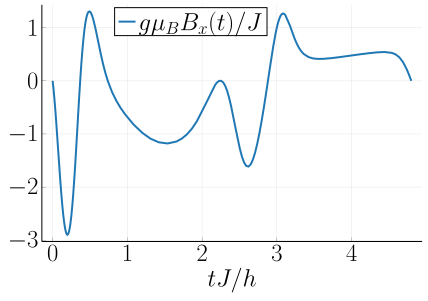

In [33]:
function Ωsol(t,p)
    envelope = smooth_square_envelope(t);
    nn_output = Ωp_nn([t/T],p);
    @inbounds Ω = envelope*nn_output[1]*sin(nn_output[2])
    return Ω
end

const fonstsize = 24;
theme(:default)

# β = J/4 and Ω = g μB B_x/2, so g μB B_x/J == Ω/(2β)
Plots.plot(τ -> Ωsol(τ / (4*β/(2π)), nn_solution)/(2*β), 0, T*(4*β)/(2π), label = L"g\mu_B B_x(t)/J", xlabel = L"t J/h", xtickfont=font(fonstsize-0), ytickfont=font(fonstsize-0), guidefont=font(fonstsize-0), legendfont=font(fonstsize-0), lw=2, palette = :tab10, legend = (0.19,0.99))

In [34]:
Plots.savefig("dqd-pulse-2nd-order.pdf")

In [14]:
function schrodinger_check(U, err, t)
    envelope = smooth_square_envelope(t);
    nn_output = Ωp_nn([t/T],nn_solution);
    @inbounds Ω = envelope*(nn_output[1]*sin(nn_output[2]) )
    βerr = β*(1+err)
    @inbounds Herr = Hermitian([βerr Ω; Ω -βerr]);
    return -im*Herr*U
end

const U0 = Complex{Float64}[1 0; 0 1;];

ode_check = ODEProblem(schrodinger_check, U0, tspan);

function fidelity(err)
    ode_sol = solve(ode_check, BS5(), p=err, abstol=tol*0.1, reltol=tol*0.1)
    Ugate = last(ode_sol)[1:2,1:2]
    return abs(1.0 - abs(tr(Ugate*Utarget[1:2,1:2]')/2)^2)
    #last(ode_sol)[4:6,1:3]
end

fidelity (generic function with 1 method)

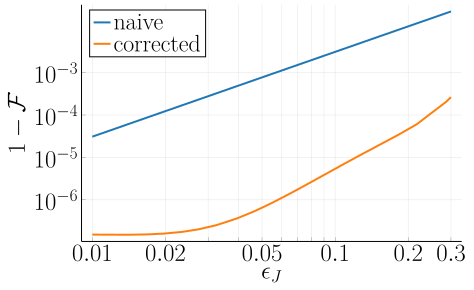

In [35]:
Plots.plot(ϵ -> 1-cos(π*ϵ/4) , 1e-2, 3.0e-1, label="naive", xlabel=L"\epsilon_J",ylabel=L"1-\mathcal F", xaxis=:log10, yaxis=:log10, xticks=([0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.2,0.3], [L"0.01",L"0.02",L"",L"",L"0.05",L"",L"",L"",L"",L"0.1",L"0.2",L"0.3"]), xformatter=LaTeXStrings.latexstring, yticks=([1e-6,1e-5,1e-4,1e-3], [L"10^{-6}",L"10^{-5}",L"10^{-4}",L"10^{-3}"]), yformatter=LaTeXStrings.latexstring, xtickfont=font(fonstsize-0), ytickfont=font(fonstsize-0), guidefont=font(fonstsize-0), legendfont=font(fonstsize-0), lw=2, palette = :tab10, legend = :topleft  )
Plots.plot!(fidelity , 1e-2, 3.0e-1, label="corrected", xlabel=L"\epsilon_J",ylabel=L"1-\mathcal F", xaxis=:log10, yaxis=:log10, xtickfont=font(fonstsize-0), ytickfont=font(fonstsize-0), guidefont=font(fonstsize-0), legendfont=font(fonstsize-0), lw=2, palette = :tab10, legend = :topleft  )

In [36]:
Plots.savefig("dqd-fidelity-2nd-order.pdf")

In [41]:
BbyJApprox = Fun(t -> Ωsol(t, nn_solution)/β, Chebyshev(Interval(0,T)) );
BbyJApproxChop = Fun(Chebyshev(Interval(0,T)), round.(coefficients(chop(BbyJApprox, 0.01)),digits=3) );
print(BbyJApproxChop)

Fun{Chebyshev{Interval{:closed,:closed,Float64},Float64},Float64,Array{Float64,1}}(Chebyshev(0.0..6.0), [-0.444, 1.428, 0.025, -0.356, -0.727, 0.356, 0.251, -0.757, 0.689, -1.112, 0.866, -0.024, -0.195, -0.094, -0.328, 0.812, -0.29, -0.214, -0.063, 0.152, 0.285, -0.309, -0.068, 0.088, 0.083, 0.016, -0.13, 0.034, 0.032])

In [42]:
ΩApproxChop(t) = BbyJApproxChop(t)*β;

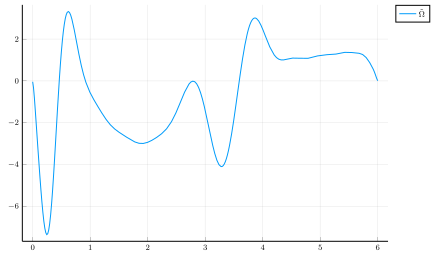

In [43]:
Plots.plot(ΩApproxChop,0,T,label=L"\tilde\Omega")

In [44]:
function schrodinger_nn_check_approx(U, err, t)
    @inbounds Ω = ΩApproxChop(t)
    βerr = β*(1+err)
    @inbounds Herr = Hermitian([βerr Ω; Ω -βerr]);
    return -im*Herr*U
end


ode_check_approx = ODEProblem(schrodinger_nn_check_approx, U0, tspan);

function fidelity_approx(err)
    ode_sol = solve(ode_check_approx, BS5(), p=err, abstol=tol, reltol=tol)
    Ugate = last(ode_sol)[1:2,1:2]
    return abs(1.0 - abs(tr(Ugate*Utarget[1:2,1:2]')/2)^2)
end

fidelity_approx (generic function with 1 method)

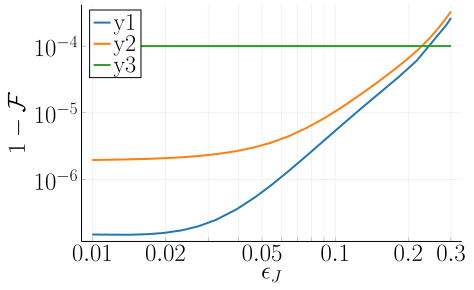

In [48]:
Plots.plot([fidelity, fidelity_approx, ϵ -> 1e-4] , 1e-2, 3.0e-1, xlabel=L"\epsilon_J",ylabel=L"1-\mathcal F", xaxis=:log10, yaxis=:log10, xticks=([0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.2,0.3], [L"0.01",L"0.02",L"",L"",L"0.05",L"",L"",L"",L"",L"0.1",L"0.2",L"0.3"]), xformatter=LaTeXStrings.latexstring, yticks=([1e-6,1e-5,1e-4,1e-3], [L"10^{-6}",L"10^{-5}",L"10^{-4}",L"10^{-3}"]), yformatter=LaTeXStrings.latexstring, xtickfont=font(fonstsize-0), ytickfont=font(fonstsize-0), guidefont=font(fonstsize-0), legendfont=font(fonstsize-0), lw=2, palette = :tab10, legend = :topleft  )

In [49]:
print(nn_solution)

Float32[1.9711244, -0.02330578, 0.39016703, -1.835375, -0.986853, -0.13756475, -0.67629933, 0.5011216, -0.52000296, 0.50247794, -0.5049826, -1.5044957, 0.36901516, -0.056995574, -1.0235007, -1.6497456, 1.2010558, -0.21040513, 1.5792434, 1.3069724, 0.35130492, -1.3628999, -0.7764146, 0.5750731, -1.0389019, 1.1464537, -0.7453591, -1.7856518, 2.044602, -0.44095162, 1.4343325, 1.4314713, -1.3365209, 0.7970154, -0.59283453, -0.19117078, -0.19915383, 1.9419644, 2.1412704, 0.7629079, -1.7158543, 1.4591956, -1.1549119, 0.12933223, 1.1928793, -0.081709854, -0.8655149, -0.13997509, -1.7671527, -2.448882, -1.2530359, 1.0553036, 0.014602142, -0.220568, 0.026181718, -0.80335, -0.8313363, 0.034791566, 0.11965886, -0.6207846, 1.1941607, 0.15086152, -0.32673684, 0.54727525, 0.37519744, 0.5911214, -0.6091069, 0.27831984, 0.34486988, -0.19007534, -0.037116952, 0.6467588, -0.032410502, -0.144463, 0.36581138, -0.027929952, 0.16380268, 0.73613364, -0.285556, 0.3749679, -0.399703, 0.31688115, 0.23109244, -0